In [29]:
#https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
path="https://raw.githubusercontent.com/Ashutoshrx/Natural-Language-Processing/main/data/train.tsv"


In [30]:
import numpy as np
import pandas as pd
import re
import string
import nltk
pd.set_option('display.max_colwidth',100)
from nltk.corpus import stopwords
ln=nltk.WordNetLemmatizer()
ps=nltk.PorterStemmer()

In [31]:
df=pd.read_csv(path, sep='\t', header=0)
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,PhraseId,SentenceId,Phrase,Sentiment,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,1,1,A series of escapades demonstrating the adage that what is good for the goose is also good for t...,1,NaN,NaN,NaN,NaN,NaN
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2,NaN,NaN,NaN,NaN,NaN
2,3,1,A series,2,NaN,NaN,NaN,NaN,NaN
3,4,1,A,2,NaN,NaN,NaN,NaN,NaN
4,5,1,series,2,NaN,NaN,NaN,NaN,NaN


In [32]:
df=df.drop(['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8','PhraseId','SentenceId'],axis=1)

In [33]:
df.shape

(156060, 2)

In [34]:
df=df.iloc[:1000,]

In [35]:
df.shape

(1000, 2)

In [36]:
#removing rows having null values
df=df.dropna(axis=0)
print(df.isna().sum())

Phrase       0
Sentiment    0
dtype: int64


In [37]:
from io import StringIO
col = ['Sentiment', 'Phrase']
df = df[col]
df = df[pd.notnull(df['Phrase'])]
df.columns = ['Sentiment', 'Phase']
df['category_id'] = df['Sentiment'].factorize()[0]
category_id_df = df[['Sentiment', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Sentiment']].values)
df.head()

,Sentiment,Phase,category_id
0,1,A series of escapades demonstrating the adage that what is good for the goose is also good for t...,0
1,2,A series of escapades demonstrating the adage that what is good for the goose,1
2,2,A series,1
3,2,A,1
4,2,series,1


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Phase).toarray()
labels = df.Sentiment
features.shape

(1000, 436)

In [39]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# '0':
  . Most correlated unigrams:
. forces
. glacial
  . Most correlated bigrams:
. frothing ex
. youth remain
# '1':
  . Most correlated unigrams:
. forces
. glacial
  . Most correlated bigrams:
. frothing ex
. youth remain
# '2':
  . Most correlated unigrams:
. forces
. glacial
  . Most correlated bigrams:
. frothing ex
. youth remain
# '3':
  . Most correlated unigrams:
. forces
. glacial
  . Most correlated bigrams:
. frothing ex
. youth remain
# '4':
  . Most correlated unigrams:
. forces
. glacial
  . Most correlated bigrams:
. frothing ex
. youth remain


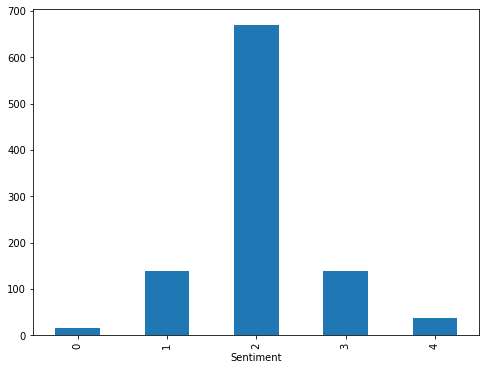

In [40]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Sentiment').Phase.count().plot.bar(ylim=0)
plt.show()

# **Naive Bayes**

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Phase'], df['Sentiment'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [42]:
#Evaluating the model
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
pred_nv = clf.predict(count_vect.transform(X_test))
#print(classification_report(y_test ,pred))
print('Confusion Matrix: \n', confusion_matrix(y_test,pred_nv))
print()
print('Naive Bayes accuracy score in %: ', accuracy_score(y_test,pred_nv)*100)

Confusion Matrix: 
 [[  0   4   1   0   0]
 [  0  12  22   0   0]
 [  0   8 168   2   0]
 [  0   1  16   9   1]
 [  0   0   5   1   0]]

Naive Bayes accuracy score in %:  75.6


# **Random Forest**

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 500, random_state = 42)
rf.fit(X_train_tfidf, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [44]:
#Evaluating the model
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
pred_rf = clf.predict(count_vect.transform(X_test))
#print(classification_report(y_test ,pred))
print('Confusion Matrix: \n', confusion_matrix(y_test,pred_rf))
print()
print('Random Forest accuracy score in %: ', accuracy_score(y_test,pred_rf)*100)

Confusion Matrix: 
 [[  0   4   1   0   0]
 [  0  12  22   0   0]
 [  0   8 168   2   0]
 [  0   1  16   9   1]
 [  0   0   5   1   0]]

Random Forest accuracy score in %:  75.6


# **SVM**

In [45]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
from sklearn import svm
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train_tfidf,y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(count_vect.transform(X_test))
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)

SVM Accuracy Score ->  73.2


# **Logistic Regression**

In [46]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train_tfidf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
y_pred_lr = logreg.predict(count_vect.transform(X_test))
print("Logistic Regression Accuracy Score -> ",accuracy_score(y_pred_lr, y_test)*100)

Logistic Regression Accuracy Score ->  69.19999999999999
